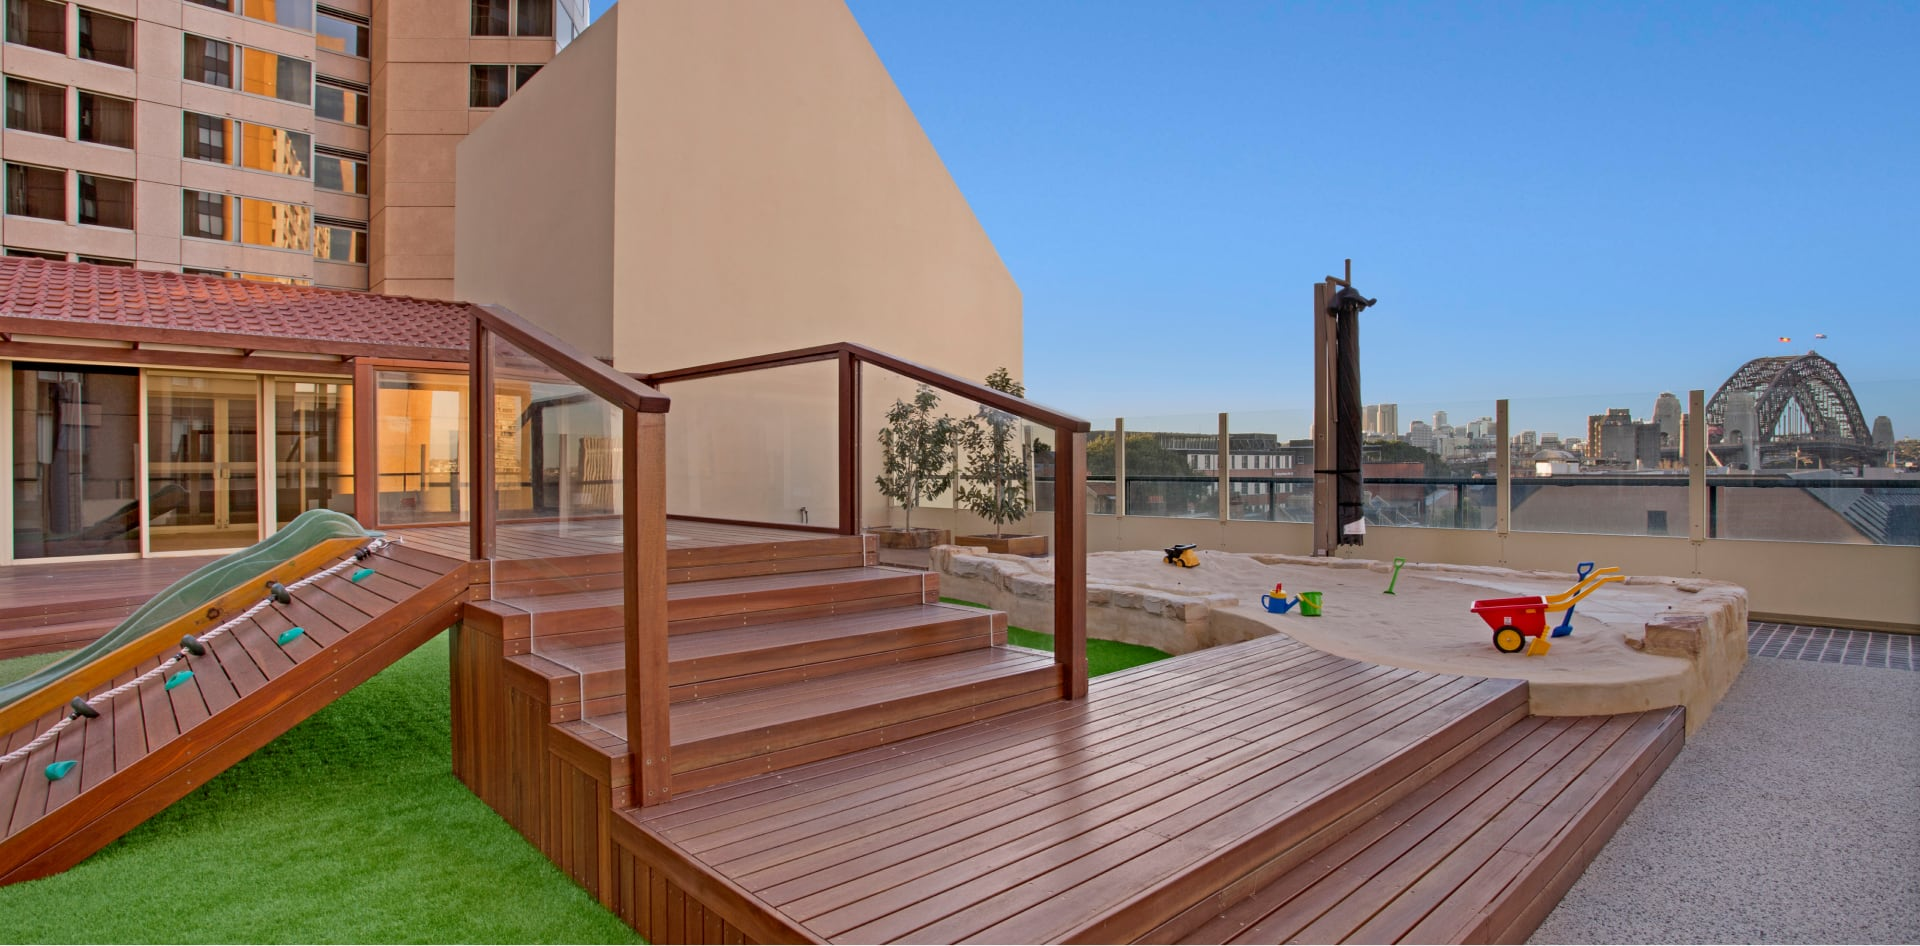

# Overview

This project aims to investigate the cost of Childcare, specifically Long day care, in the Sydney region, as well as the relationship between childcare fees and family incomes. Publically available data from the Australian Bureau of Statistics (ABS) was used for the analysis.

The raw data is categorised into regional areas of Sydney defined as Statistical Areas 3 (SA3). These are defined by the ABS as follows:


`SA3s are designed to provide a regional breakdown of Australia. They generally have a population of between 30,000 and 130,000 people. In regional areas, SA3s represent the area serviced by regional cities that have a population over 20,000 people. In the major cities, SA3s represent the area serviced by a major transport and commercial hub. They often closely align to large urban Local Government Areas (e.g. Gladstone, Geelong). In outer regional and remote areas, SA3s represent areas which are widely recognised as having a distinct identity and similar social and economic characteristics.`

[ABS source](https://www.abs.gov.au/ausstats/abs@.nsf/Lookup/by%20Subject/1270.0.55.001~July%202016~Main%20Features~Statistical%20Area%20Level%203%20(SA3)~10015.html)

This categorisation allows us to look at how childcare prices vary across the different regions as well as how the median incomes in each region are related to childcare prices

The investigation is split into 3 sections:

    1. Childcare fees by regional area of Sydney
    2. Geographic mapping of childcare prices
    3. Childcare fees vs family incomes

# Attributions

### Childcare data

Australian Bureau of Statistics (Updated 26/07/2017) 'Childcare Administrative data' [data set], accessed 16 December 2020.

url: https://data.gov.au/data/dataset/9923c11b-aa7e-4bb6-afd9-b17674347fdd/resource/5b6f578d-1d1e-4f97-a285-706dafdb9cbc/download/child-care-administrative-data.csv

This data set contains information for Child Care Benefit (CCB) approved child care services in Greater Sydney and Greater Melbourne (as defined by the Greater Capital City Statistical Areas – GCCSA). It includes information relating to long day care (LDC), after school hours care (ASC) and before school hours care (BSC) services.

### Geographic data

Australian Bureau of Statistics '2016 Census Datapacks, General Community Profile, Statistical Area 3' [Shapefile], accessed 29 December 2020.

url: https://datapacks.censusdata.abs.gov.au/datapacks/

### Family income data

Australian Bureau of Statistics '2016 Census Datapacks, General Community Profile, Statistical Area 3' [data set], accessed 29 December 2020.

url: https://datapacks.censusdata.abs.gov.au/datapacks/

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shapefile as shp
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import re
import scipy.stats

# Contents

1. Childcare data<br>
    1.1 Mean hourly fee<br>
    1.2 Mean hourly fee distribution<br>
2. Plot geographic data<br>
3. Family income data<br>
    3.1 Median income calculation<br>
    3.2 Childcare fees vs family income<br>


# 1. Childcare data

Firstly, we'll look at the Childcare Administrative data (Source: Australian Bureau of Statistics, 2017). This dataset contains mean annual childcare fee data for each each Australian SA3 region. The value for each region represents the average fee across all of the childcare centres within that region. Data is listed for several financial years, and for several service types, although in this analysis we are interested in Long Day Care (LDC).

Firstly, import the dataset into a pandas dataframe.

In [2]:

url='https://data.gov.au/data/dataset/9923c11b-aa7e-4bb6-afd9-b17674347fdd/resource/5b6f578d-1d1e-4f97-a285-706dafdb9cbc/download/child-care-administrative-data.csv'
url_meta='https://data.gov.au/data/dataset/9923c11b-aa7e-4bb6-afd9-b17674347fdd/resource/d776a27b-09ae-4b43-9f86-9d751212cbb2/download/child-care-administrative-data-dictionary.csv'

metadata=pd.read_csv(url_meta, encoding='cp1252')
df=pd.read_csv(url)

Examine data types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4042 entries, 0 to 4041
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SA3_code_2011  4042 non-null   int64 
 1   SA3_name_2011  4042 non-null   object
 2   FY             4042 non-null   object
 3   Servicetype    4042 non-null   object
 4   child_age      4042 non-null   object
 5   child_count    4042 non-null   object
 6   service_count  4042 non-null   object
 7   fee_hr_mean    4042 non-null   object
 8   fee_hr_std     4042 non-null   object
dtypes: int64(1), object(8)
memory usage: 284.3+ KB


The columns 'service_count' and 'child_count' are objects but these need to be converted into numerical data types so the data can be used for analysis.

Inspect the dataframe to see why these columns aren't numerical types

In [4]:
df.head(10)

SA3_code_2011 SA3_name_2011        FY Servicetype child_age child_count  \
0          10201       Gosford  FY201213         ASC    1: 0-4         100   
1          10201       Gosford  FY201213         ASC    2: 5-9       2,420   
2          10201       Gosford  FY201213         ASC    3: 10+         620   
3          10201       Gosford  FY201213         ASC  9: Total       3,140   
4          10201       Gosford  FY201213         BSC    1: 0-4          60   
5          10201       Gosford  FY201213         BSC    2: 5-9       1,380   
6          10201       Gosford  FY201213         BSC    3: 10+         360   
7          10201       Gosford  FY201213         BSC  9: Total       1,810   
8          10201       Gosford  FY201213         LDC    1: 0-4       6,820   
9          10201       Gosford  FY201213         LDC    2: 5-9       1,380   

  service_count fee_hr_mean fee_hr_std  
0            28       $6.00      $0.95  
1            28       $6.00      $0.95  
2            28       $6.00      $0.95  
3            28       $6.00      $0.95  
4            28       $6.70      $1.10  
5            28       $6.70      $1.10  
6            28       $6.70      $1.10  
7            28       $6.70      $1.10  
8            67       $7.15      $0.85  
9            67       $7.15      $0.85

Remove unwanted symbols from the data and convert to integer data type

In [5]:
# (str functions only work on pd.series so need to use df.apply on multiple cols)
col = ['service_count','child_count']
df[col] = df[col].apply(lambda x: x.str.replace(',',''))
df[col] = df[col].apply(lambda x: x.str.replace('<',''))     
df[col] = df[col].astype(int)

Filter the data keep only pertinent information
* Select areas in Greater Sydney only
* Select only long day care

Save as a new dataframe to keep original information intact

In [6]:
# Select Sydney areas only. Sydney regions are in the range of SA3 codes between 11501 and 12802.
dg = df[(df['SA3_code_2011'] >= 11501) & (df['SA3_code_2011'] <= 12802)].copy()

# filter out all but long day care
dg = dg[dg['Servicetype'] == 'LDC']

### 1.1 Mean hourly fee

Next, we can look at the distribution of mean hourly fee across all of the Sydney regions listed in the data

* Select only the combined data for all children. We don't need data categorised by the childs age.

* Convert hourly fee data into a numerical data type

* Plot mean hourly fee across all localities

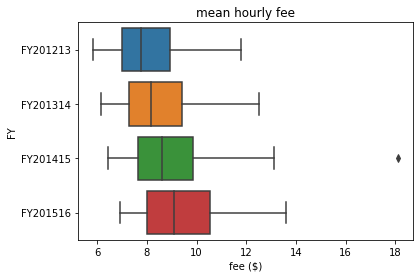

In [7]:
# Select combined data for all children 
dg = dg[dg['child_age'] == '9: Total'].copy()

# Remove unwanted symbols from the data so that it can be converted to a numeric data type
dg['fee_hr_mean'] = dg['fee_hr_mean'].astype(str).str.lstrip('$').astype(float)
dg['fee_hr_std'] = dg['fee_hr_std'].astype(str).str.lstrip('$').astype(float)

#plot mean hourly fees for all localities
sns.boxplot(x='fee_hr_mean', y='FY', data=dg)
plt.title('mean hourly fee')
plt.xlabel('fee ($)')
plt.show()

* Mean hourly fee is positively skewed, with a median of approximately $9 in FY 2015/16.
* Childcare fees have increased year on year from FY 2021/13 to FY 2015/16


Now, look at the change in the median fee over time in more detail.

In [8]:
# Group by financial year, and calculate median
x = dg.groupby('FY').median()['fee_hr_mean']

# Plot median fee vs financial year
plt.plot(x.index, x, marker='o', linestyle='')
plt.xlabel('FY')
plt.ylabel('median fee ($)')
plt.title('Change in median fee over time')
plt.show()

# percentage change
y = (x[-1] - x[0]) / x[0] * 100
print('Median childcare fees across the Greater Sydney area have increased by {:.1f} % over the 3 years to FY2015/16\n'.format(y))

Median childcare fees across the Greater Sydney area have increased by 17.0 % over the 3 years to FY2015/16



Fees increased approximately linearly between FY2012/13 and FY2014/15, but FY 2015/16 saw a slightly larger increase in fees compared with previous years.

***
### 1.2 Mean hourly fee distribution
Next, plot the hourly fee standard deviation for each financial year

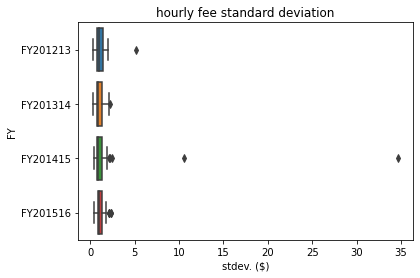

In [9]:
#plot hourly fee standard deviation for all localities
sns.boxplot(x='fee_hr_std', y='FY', data=dg)
plt.title('hourly fee standard deviation')
plt.xlabel('stdev. ($)')
plt.ylabel('FY')
plt.show()

Several outliers are present in the standard deviations. These can be investigated further:

In [10]:
dg[dg['fee_hr_std']>2]

SA3_code_2011             SA3_name_2011        FY Servicetype child_age  \
118           11501            Baulkham Hills  FY201314         LDC  9: Total   
141           11501            Baulkham Hills  FY201516         LDC  9: Total   
559           11703         Sydney Inner City  FY201415         LDC  9: Total   
570           11703         Sydney Inner City  FY201516         LDC  9: Total   
592           11801   Eastern Suburbs - North  FY201314         LDC  9: Total   
614           11801   Eastern Suburbs - North  FY201516         LDC  9: Total   
636           11802   Eastern Suburbs - South  FY201314         LDC  9: Total   
647           11802   Eastern Suburbs - South  FY201415         LDC  9: Total   
658           11802   Eastern Suburbs - South  FY201516         LDC  9: Total   
933           12002                Leichhardt  FY201415         LDC  9: Total   
945           12002                Leichhardt  FY201516         LDC  9: Total   
1024          12101     Chatswood - Lane Cove  FY201415         LDC  9: Total   
1825          12504                Parramatta  FY201415         LDC  9: Total   
1944          12701  Bringelly - Green Valley  FY201213         LDC  9: Total   

      child_count  service_count  fee_hr_mean  fee_hr_std  
118          7550             65         8.95        2.25  
141          8220             74         9.85        2.35  
559          8370             82        12.10        2.40  
570          8960             96        12.55        2.10  
592          5300             61        12.50        2.10  
614          5950             70        13.60        2.05  
636          5020             57        10.80        2.05  
647          5230             57        11.25        2.05  
658          5310             58        11.85        2.15  
933          3140             28        18.10       34.65  
945          3330             30        12.50        2.30  
1024         5320             53        12.85       10.60  
1825         7130             73         8.45        2.20  
1944         5470             56         7.10        5.10

The standard deviations of 34.65 and 10.60 seem suspiciously high. For these data points, the standard deviation for preceding and subsequent financial years was much lower, suggesting that the data could possibly be erroneous. A very small service count could indicate that one or two services are skewing the data, but the number of services are >= 28 for both of these data points, so this seems to not be the case.

Let's remove data points with a standard deviation > 3 from further analysis

In [11]:
dg = dg[dg['fee_hr_std']<3]

***
# 2. Plot geographic data


Next, we take the mean hourly fee data and display it visually on a map

The map of SA3 regions is provided as a Shapefile (Australian Bureau of Statistics, 2016)

First, open the Shapefile

In [12]:
# File path
shp_path = r'.\data\2016_SA3_shape\SA3_2016_AUST.shp'

# reading the shape file by using reader function of the shape lib
sf = shp.Reader(shp_path)

# Check fields in the shapefile
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['SA3_CODE', 'C', 5, 0],
 ['SA3_CODE16', 'C', 5, 0],
 ['SA3_NAME', 'C', 50, 0],
 ['STATE_CODE', 'C', 1, 0],
 ['STATE_NAME', 'C', 50, 0],
 ['AREA_SQKM', 'N', 31, 15]]

Define some functions for analysing the Shapefile

In [13]:
def read_shapefile(sf):
    '''
    function for converting a shapefile into pandas dataframe format
    '''
    #fetch the headings from the shape file
    fields = [x[0] for x in sf.fields][1:]
    
    #fetch the records from the shape file
    records = [list(i) for i in sf.records()]
    shapes = [s.points for s in sf.shapes()]
    
    #convert shapefile data into pandas dataframe
    df = pd.DataFrame(columns=fields, data=records)
    
    #assign the coordinates
    df = df.assign(coords=shapes)
    
    return df

In [14]:
def get_cmap(val):
    '''
    Returns a RGBA colormap value from the float value passed to the function
    The value should be between 0 and 1
    '''
    cmap = cm.get_cmap('viridis')
    
    return list(cmap(val))

In [15]:
def plot_shape(df, xlim=None, ylim=None, text=True):
    '''
    function for plotting a geographic area using coordinate date passed via a dataframe.
    '''
    fig = plt.figure(figsize=(18,18))
    
    #plotting the graphical axes where map ploting will be done
    ax = plt.axes()
    ax.set_aspect('equal')
     
    # iterate over rows (geographic areas)
    for index, row in df.iterrows():
        
        # extract the latitude and longitude data from the current row
        lat = np.array(row['coords'])[:,0]
        long = np.array(row['coords'])[:,1]
        
        # map the fee for the current row to a colour
        # plot the colour using the ax.fill method
        color = get_cmap(row['fee_norm'])
        ax.fill(lat, long, facecolor=color)
    
        # Add the area name to the plot
        if text==True:
            x0 = np.mean(lat)
            y0 = np.mean(long)
            # Clip text to the plot boundaries
            plt.text(x0, y0, row['SA3_NAME'], fontsize=9).set_clip_on(True)
    
    # Set plot limits and title
    if xlim!=None:
        plt.xlim(xlim)
    if ylim!=None:
        plt.ylim(ylim)
    
    plt.title('Mean hourly childcare fees ($)', fontsize='x-large')
    
    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(maximum,minimum))
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)
    
    plt.show()

Convert the shapefile into a dataframe and merge with the Childcare dataframe

In [16]:
# Convert to dataframe
df = read_shapefile(sf)

# Convert integer columns to int datatype
integer_cols = ['SA3_CODE', 'SA3_CODE16', 'STATE_CODE']
df[integer_cols] = df[integer_cols].astype(int)

# Convert the 'coords' col from a list of tuples to a nested list to allow for easier manipulation
df['coords'] = [[list(j) for j in i] for i in df['coords']]

# Merge the childcare data and geographic data dataframes
# Filter out all but Sydney suburbs
df_merge = pd.merge(dg, 
                    df[(df['SA3_CODE'] >= 11501) & (df['SA3_CODE'] <= 12802)].copy(), 
                    left_on='SA3_code_2011', right_on='SA3_CODE', how='outer')   

# Restrict to FY2015/16 only
df_merge = df_merge[df_merge['FY']=='FY201516']

Normalise the mean hourly fee for plotting as a colormap 

In [17]:
minimum = df_merge['fee_hr_mean'].min()
maximum = df_merge['fee_hr_mean'].max()
# Normalise to a range of 0 to 1
df_merge['fee_norm'] = (df_merge['fee_hr_mean'] - minimum) / (maximum - minimum)

Plot the data 

In [18]:
plot_shape(df_merge)

Plot a zoomed in map

In [19]:
plot_shape(df_merge, xlim=(150.8, 151.4), ylim=(-34.1,-33.5))

It is clear from the geographic data that the areas with the most expensive childcare are clustered around Sydney Harbour, including the Eastern Suburbs - North, North Sydney - Mosman and Sydney Inner City. Prices remain high through the Northern suburbs, Northern beaches, Inner west and Eastern Suburbs - South regions.  

However, moving to the Northwestern, Western and Southwestern suburbs results in significantly cheaper fees, in the order of half the amount compared to the most expensive suburbs.

***
# 3. Family income data

Load family income data for the same geographical regions and merge with the childcare and mapping data.
Use the merged data to correlate income with childcare fees.

First, load the income data and convert to dataframe format.

In [20]:
# The data is spread over 2 data files
filepathA = r'.\data\2016_TSP_SA3_for_NSW_short-header\2016 Census TSP Statistical Area 3 for NSW\2016Census_T22A_NSW_SA3.csv'
filepathB = r'.\data\2016_TSP_SA3_for_NSW_short-header\2016 Census TSP Statistical Area 3 for NSW\2016Census_T22B_NSW_SA3.csv'

# Convert to dataframes
data1 = pd.read_csv(filepathA)
data2 = pd.read_csv(filepathB)

# Concatenate the 2 dataframes
dg = pd.concat([data1, data2], axis=1)

dg.describe()

SA3_CODE_2016  C06_N_in_CF_1C  C06_N_in_CF_2C  C06_N_in_CF_3C  \
count      94.000000       94.000000       94.000000       94.000000   
mean    11593.723404       16.180851       13.659574        5.882979   
std      1468.242058       15.588087       13.988131        6.562940   
min     10102.000000        0.000000        0.000000        0.000000   
25%     10728.250000        7.000000        4.250000        3.000000   
50%     11451.500000       12.000000       10.000000        4.000000   
75%     12176.750000       19.750000       17.750000        8.000000   
max     19999.000000       75.000000       85.000000       45.000000   

       C06_N_in_Cou_fa_4mor_c  C06_N_in_CF_T  C06_1_149_CF_1C  \
count               94.000000      94.000000        94.000000   
mean                 2.265957      38.223404        16.436170   
std                  4.077675      36.840007        16.651752   
min                  0.000000       0.000000         0.000000   
25%                  0.000000      15.250000         6.000000   
50%                  0.000000      31.000000        13.000000   
75%                  3.000000      45.500000        18.000000   
max                 20.000000     225.000000        89.000000   

       C06_1_149_CF_2C  C06_1_149_CF_3C  C06_1_149_CF_4mC  ...  \
count        94.000000        94.000000         94.000000  ...   
mean         15.117021         5.989362          3.010638  ...   
std          15.254019         6.956848          5.156674  ...   
min           0.000000         0.000000          0.000000  ...   
25%           6.250000         3.000000          0.000000  ...   
50%          11.000000         4.000000          0.000000  ...   
75%          19.000000         7.000000          3.750000  ...   
max         110.000000        39.000000         26.000000  ...   

       C16_All_inc_ns_CF_1Ch  C16_All_inc_ns_CF_2C  C16_All_inc_ns_CF_3C  \
count              94.000000             94.000000             94.000000   
mean               33.021277             33.489362             15.223404   
std                21.484668             24.209100             13.781048   
min                 0.000000              0.000000              0.000000   
25%                19.000000             17.000000              7.250000   
50%                28.000000             26.000000             12.000000   
75%                43.000000             48.000000             19.000000   
max               109.000000            136.000000             84.000000   

       C16_All_inc_ns_CF_4mC  C16_All_inc_ns_CF_T  C16_Tot_CF_1C  \
count              94.000000            94.000000      94.000000   
mean                6.946809            88.851064    3418.308511   
std                 8.750259            64.421655    2300.222832   
min                 0.000000             0.000000       0.000000   
25%                 3.000000            50.000000    1658.000000   
50%                 4.000000            70.500000    2855.500000   
75%                 8.000000           117.750000    5130.750000   
max                45.000000           377.000000    8867.000000   

       C16_Tot_CF_2C  C16_Tot_CF_3C  C16_Tot_CF_4mC  C16_Tot_CF_T  
count      94.000000      94.000000       94.000000     94.000000  
mean     3958.904255    1525.670213      537.308511   9439.893617  
std      2755.081967    1037.823564      476.866272   6353.321560  
min         0.000000       0.000000        0.000000      0.000000  
25%      1754.500000     771.500000      268.250000   4569.750000  
50%      3417.500000    1286.000000      410.000000   8204.500000  
75%      6476.500000    2161.000000      641.750000  14753.000000  
max     11559.000000    4664.000000     2483.000000  24842.000000  

[8 rows x 257 columns]

The 'SA3_CODE_2016' column is duplicated in the 2 data files, so need to remove duplicate columns

In [21]:
dg = dg.loc[:,~dg.columns.duplicated()]

This data uses 2016 SA3 codes whereas the previous data uses 2011 SA3 codes. The shapefile lists both the 2016 and 2011 codes, so we can use this data to check whether these are equivalent

In [22]:
tmp = df['SA3_CODE']==df['SA3_CODE16']
tmp.value_counts()

True    358
dtype: int64

The 2016 and 2011 SA3 codes are equivalent so we can use these interchangeably

Filter out Sydney suburbs only

In [23]:
dg = dg[(dg['SA3_CODE_2016'] >= 11501) & (dg['SA3_CODE_2016'] <= 12802)]

The data provided includes counts of total family income binned into a number of income ranges, and also total family income by number of children in the household.

Subset the data:
* data from 2016 only
* total family incomes
* ignore data subset into number of children in the household 

In [24]:
columns = [col for col in dg.columns if re.search('C16.+CF_T',col)]
columns.insert(0, 'SA3_CODE_2016')
dg=dg[columns]

Remove data where no/partial income data was provided.

Remove the total column.

In [25]:
columns = [col for col in dg.columns if re.search('.+inc.+T',col) or re.search('.+Tot.+T',col)]
dg = dg.drop(columns, axis=1)
dg.head()

SA3_CODE_2016  C16_N_in_CF_T  C16_1_149_CF_T  C16_150_299_CF_T  \
47          11501             88              32                52   
48          11502             15               3                 3   
49          11503              7               0                 8   
50          11504             18               3                 7   
51          11601            107              38                64   

    C16_300_399_CF_T  C16_400_499_CF_T  C16_500_649_CF_T  C16_650_799_CF_T  \
47                39                72               158               240   
48                 3                17                28                34   
49                 0                10                23                26   
50                13                12                27                48   
51                55               184               282               461   

    C16_800_999_CF_T  C16_1000_1499_CF_T  C16_1500_1999_CF_T  \
47               404                1517                2072   
48                70                 292                 363   
49                73                 330                 489   
50                93                 370                 577   
51               769                2741                3034   

    C16_2000_2499_CF_T  C16_2500_2999_CF_T  C16_3000_3999_CF_T  C16_4000m_CF_T  
47                2961                2617                4584            6469  
48                 400                 392                 628             951  
49                 541                 475                 538             447  
50                 790                 751                1128            1205  
51                3258                2236                2417            1489

As the data is binned this creates some difficulty in calculating the mean or median income for each SA3 Code.

As the last category has no upper bound, we cannot accurately calculate the mean as we can't assess the range of values within this bin. For example there could be some data points with very high income values that would skew the mean income. This is often the case with incomes which are generally positively skewed.

So, it makes more sense in this case to use the median income as our metric.

### 3.1 Median income calculation
Create a new dataframe with the cumulative counts for each income group. The median income family is the cumulative sum for all the income groups divided by 2. Eg, if the cumulative sum over all the income groups is 3999, the median will be the 2000th family. 

The median value will typically fall between a bin, but we can estimate the exact median income based on where the median falls within a bin. 

After calculating all of the cumulative sums, we set all values below the median to zero. The median bin is then the first non-zero column in each row. 

In [26]:
# create a new dataframe with the cumulative sums
dh = dg.copy()
dh.iloc[:, 1:] = dh.iloc[:, 1:].cumsum(axis=1)

# Replace columns where the cumulative sum is less than the median with zero. Don't include the first column, 
# which is the SA3 codes in the calculation.
dh.iloc[:, 1:] = dh.iloc[:, 1:].apply(lambda x: np.where(x >= dh.iloc[:, -1]/2, x , 0), axis=0)
dh['SA3_CODE_2016'] = dh['SA3_CODE_2016'].astype('int')
dh.head()

SA3_CODE_2016  C16_N_in_CF_T  C16_1_149_CF_T  C16_150_299_CF_T  \
47          11501              0               0                 0   
48          11502              0               0                 0   
49          11503              0               0                 0   
50          11504              0               0                 0   
51          11601              0               0                 0   

    C16_300_399_CF_T  C16_400_499_CF_T  C16_500_649_CF_T  C16_650_799_CF_T  \
47                 0                 0                 0                 0   
48                 0                 0                 0                 0   
49                 0                 0                 0                 0   
50                 0                 0                 0                 0   
51                 0                 0                 0                 0   

    C16_800_999_CF_T  C16_1000_1499_CF_T  C16_1500_1999_CF_T  \
47                 0                   0                   0   
48                 0                   0                   0   
49                 0                   0                   0   
50                 0                   0                   0   
51                 0                   0                   0   

    C16_2000_2499_CF_T  C16_2500_2999_CF_T  C16_3000_3999_CF_T  C16_4000m_CF_T  
47                   0                   0               14836           21305  
48                   0                1620                2248            3199  
49                1507                1982                2520            2967  
50                   0                2709                3837            5042  
51               10993               13229               15646           17135

Add four new columns:
* 'minimum': the bin containing the median
* 'min_idx': the column name containing the median
* 'min_income : extract the min income of the bin from the column name
* 'max income' : extract the max income of the bin from the column name

In [27]:
dh['minimum'] = dh[dh.iloc[:,1:]!=0].min(axis=1)
dh['min_idx'] = dh[dh.iloc[:,1:]!=0].idxmin(axis=1) 
dh['min_income'] = dh['min_idx'].str.extract(("_(.*?)_"))
dh['max_income'] = dh['min_idx'].str.strip('C16_').str.extract(("_(.*?)_"))

We can also extract the bin below the one containing the median. The value in this bin represents the lower bound of the bin containing the median.

In [28]:
dj = dg.copy()

# Evaluate the cumulative sums
dj.iloc[:, 1:] = dj.iloc[:, 1:].cumsum(axis=1)

# Replace columns where the cumulative sum is greater than the median with zero. Don't include the first column, 
# which is the SA3 codes in the calculation.
dj.iloc[:, 1:] = dj.iloc[:, 1:].apply(lambda x: np.where(x >= dj.iloc[:, -1]/2, 0 , x), axis=0)

# The bin below the median bin is the maximum of the cumulative sums
dh['minimum_b'] = dj.iloc[:,1:].max(axis=1)

The min and max income columns need to be converted to numeric data types. First remove or replace any non-numeric symbols

In [29]:
dh['min_income'] = dh['min_income'].str.strip('m')
dh['max_income'] = dh['max_income'].str.replace('CF', 'NaN')
dh[['min_income', 'max_income']] = dh[['min_income', 'max_income']].astype('float')

We can estimate the median by calculating where the median falls within the bin.
* Assume a uniform distribution within the bins
* Calculate an adjustment value which is 
= ((median count) - (lower bound of the median bin)) / (bin size)

The adjustment value represents the position of the median within the bin on a scale of 0 - 1

In [30]:
dh['adjustment'] = (dh['C16_4000m_CF_T'] / 2 - dh['minimum_b']) / (dh['minimum'] - dh['minimum_b'])

Use the adjustment value to  calculate the median

In [31]:
dh['median'] = dh['min_income'] + (dh['max_income'] - dh['min_income']) * dh['adjustment']
dh['median'] = np.where(np.isnan(dh['max_income']), dh['min_income'], dh['median'])
dh.head()

SA3_CODE_2016  C16_N_in_CF_T  C16_1_149_CF_T  C16_150_299_CF_T  \
47          11501              0               0                 0   
48          11502              0               0                 0   
49          11503              0               0                 0   
50          11504              0               0                 0   
51          11601              0               0                 0   

    C16_300_399_CF_T  C16_400_499_CF_T  C16_500_649_CF_T  C16_650_799_CF_T  \
47                 0                 0                 0                 0   
48                 0                 0                 0                 0   
49                 0                 0                 0                 0   
50                 0                 0                 0                 0   
51                 0                 0                 0                 0   

    C16_800_999_CF_T  C16_1000_1499_CF_T  ...  C16_2500_2999_CF_T  \
47                 0                   0  ...                   0   
48                 0                   0  ...                1620   
49                 0                   0  ...                1982   
50                 0                   0  ...                2709   
51                 0                   0  ...               13229   

    C16_3000_3999_CF_T  C16_4000m_CF_T  minimum             min_idx  \
47               14836           21305  14836.0  C16_3000_3999_CF_T   
48                2248            3199   1620.0  C16_2500_2999_CF_T   
49                2520            2967   1507.0  C16_2000_2499_CF_T   
50                3837            5042   2709.0  C16_2500_2999_CF_T   
51               15646           17135  10993.0  C16_2000_2499_CF_T   

    min_income max_income  minimum_b  adjustment       median  
47      3000.0     3999.0      10252    0.087369  3087.281741  
48      2500.0     2999.0       1228    0.947704  2972.904337  
49      2000.0     2499.0        966    0.956562  2477.324399  
50      2500.0     2999.0       1958    0.749667  2874.083888  
51      2000.0     2499.0       7735    0.255525  2127.506906  

[5 rows x 22 columns]

### 3.2 Childcare fees vs family income
Plot the mean hourly childcare fees vs median weekly family income

Firstly, merge the dataframe with the original dataframe containing the childcare fee and geographic data

In [32]:
df_final = pd.merge(df_merge, dh[['SA3_CODE_2016', 'median']], 
                    left_on='SA3_code_2011', right_on='SA3_CODE_2016', how='outer')

Plot the data along with a linear fit

In [33]:
# strip NaN rows (needed for linear fit)
df_final = df_final[~df_final[['median', 'fee_hr_mean']].isna().any(axis=1)]

# Plot the mean hourly childcare fees vs median weekly family income
plt.scatter(df_final['median'], df_final['fee_hr_mean'])

# Fit a first order polynomial (linear fit) to the data
terms = np.polynomial.polynomial.polyfit(df_final['median'], df_final['fee_hr_mean'], 1)

# Plot the linear fit
x = np.linspace(df_final['median'].min(), df_final['median'].max(), 2)
plt.plot(x, terms[0] + terms[1] * x)

plt.title('Childcare fees vs family income')
plt.xlabel('Median weekly family income ($)')
plt.ylabel('Mean hourly fee ($)')
plt.show()

Calculate the pearson r and pearson r squared values to evaluate the strength of the linear relationship

In [34]:
pearson_r = scipy.stats.pearsonr(df_final['median'], df_final['fee_hr_mean'])
pearson_r_sqr = pearson_r[0] ** 2
print('Pearson r value = {:.2f}'.format(pearson_r[0]))
print('Pearson r squared value = {:.2f}'.format(pearson_r_sqr))

Pearson r value = 0.89
Pearson r squared value = 0.79


The r value of 0.89 indicates a strong linear correlation between mean hourly childcare fees vs median weekly family income

The r squared value of 0.79 indicates that approximately 80% of the variation in childcare fees can be explained by the value of weekly family income.